In [45]:
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import networkx as nx

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

In [3]:
# Forecasts
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_forecasts.geojson')

In [6]:
random_color = lambda: np.random.random(3)

In [7]:
# look at the forecasts
day1_forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2021-07-28T08:00:00,70,1,POINT (-69.75497 37.90491)
1,1,24,2021-07-28T20:00:00,75,1,POINT (-70.50738 38.86856)
2,1,36,2021-07-29T08:00:00,85,2,POINT (-71.35866 39.41313)
3,1,48,2021-07-29T20:00:00,85,2,POINT (-71.72152 40.51758)
4,1,60,2021-07-30T08:00:00,100,3,POINT (-71.48969 41.18486)
...,...,...,...,...,...,...
155,20,48,2021-07-29T20:00:00,85,2,POINT (-71.49297 40.27587)
156,20,60,2021-07-30T08:00:00,100,3,POINT (-70.95934 42.12895)
157,20,72,2021-07-30T20:00:00,105,3,POINT (-71.61717 40.70945)
158,20,96,2021-07-31T20:00:00,90,2,POINT (-70.44554 43.65152)


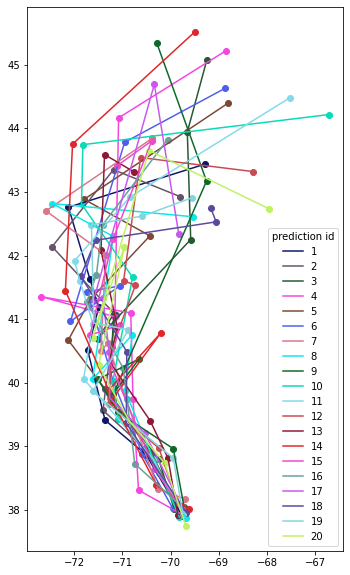

In [16]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in day1_forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')

<AxesSubplot:>

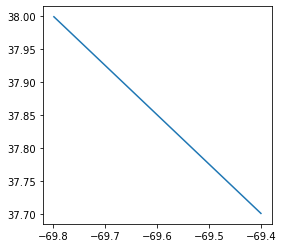

In [17]:
# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_track_past.geojson')
day1_track.plot()

# Game Grid
This is the grid that represents the scope of the response, and also the transportation network
It uses the [Military Grid Reference System](https://en.wikipedia.org/wiki/Military_Grid_Reference_System) to divide the world into a grid. There is a unique alphanumeric string that identifies each cell. We are working at the 1km resolution of the grid. See also the [US National Grid](https://www.fgdc.gov/usng/how-to-read-usng) which is nearly identical, except for some [edge-cases](https://www.maptools.com/tutorials/mgrs_usng_diffs).

In [2]:
# downloading pre-hurricane game grid (pretty big file ~ 111 MB)
!wget https://files.bwsi-remote-sensing.net/data/final/game_grid_2021.geojson

--2021-07-29 14:08:49--  https://files.bwsi-remote-sensing.net/data/final/game_grid_2021.geojson
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 54.201.56.223, 44.225.198.165, 100.20.1.230, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|54.201.56.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116721567 (111M)
Saving to: ‘game_grid_2021.geojson’

game_grid_2021.geoj 100%[===================>] 111.31M   213MB/s    in 0.5s    

2021-07-29 14:08:50 (213 MB/s) - ‘game_grid_2021.geojson’ saved [116721567/116721567]



In [134]:
game_grid = gpd.read_file('game_grid_2021.geojson')
game_grid = game_grid.drop_duplicates(subset=['MGRS'])

In [135]:
game_grid = game_grid.reset_index().drop(['index'], axis=1)
game_grid

,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score,geometry
0,596000mE,4984000mN,WQ,18T,400000.000000,18TWQ9684,18TWQ98,1,"POLYGON ((-73.76921 45.00282, -73.78190 45.002..."
1,597000mE,4984000mN,WQ,18T,400000.000000,18TWQ9784,18TWQ98,1,"POLYGON ((-73.75653 45.00268, -73.76921 45.002..."
2,598000mE,4984000mN,WQ,18T,400000.000000,18TWQ9884,18TWQ98,1,"POLYGON ((-73.74384 45.00254, -73.75653 45.002..."
3,599000mE,4984000mN,WQ,18T,400000.000000,18TWQ9984,18TWQ98,1,"POLYGON ((-73.73116 45.00240, -73.74384 45.002..."
4,579000mE,4983000mN,WQ,18T,400000.000000,18TWQ7983,18TWQ78,1,"POLYGON ((-73.98504 44.99594, -73.99773 44.996..."
...,...,...,...,...,...,...,...,...,...
196817,282000mE,4558000mN,BF,19T,0.041828,19TBF8258,19TBF85,1,"POLYGON ((-71.58574 41.14431, -71.59765 41.144..."
196818,283000mE,4558000mN,BF,19T,0.041828,19TBF8358,19TBF85,1,"POLYGON ((-71.57384 41.14458, -71.58574 41.144..."
196819,284000mE,4558000mN,BF,19T,0.041828,19TBF8458,19TBF85,1,"POLYGON ((-71.56193 41.14484, -71.57384 41.144..."
196820,285000mE,4558000mN,BF,19T,0.041828,19TBF8558,19TBF85,1,"POLYGON ((-71.55003 41.14511, -71.56193 41.144..."


<AxesSubplot:>

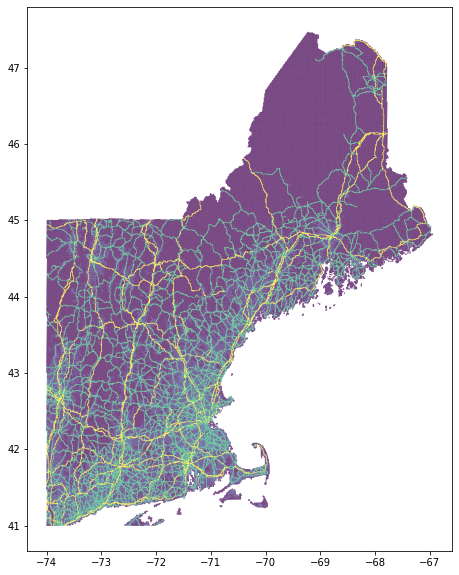

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
game_grid.plot(column='transport_score', ax=ax)

In [ ]:
game_grid_copy = game_grid.copy()
edges = gpd.sjoin(game_grid, game_grid_copy, how='inner', op='touches')
edges

In [106]:
graph = nx.Graph()
for i, r in game_grid.iterrows():
    graph.add_node(r['MGRS'])

In [107]:
count = 0
for i, r in edges.iterrows():
    if(count % 100000 == 0):
        print(count)
    node1 = r['MGRS_left']
    node2 = r['MGRS_right']
    edge_weight = 20. / (r['transport_score_left'] + r['transport_score_right'])
    if(node1 != node2):
        graph.add_edge(node1, node2, weight=edge_weight)
    count += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000


In [123]:
w,s,e,n = game_grid.total_bounds
print(w,s,e,n)

-74.0062751207002 40.995556258214776 -66.93832921282291 47.46624330268622


In [59]:
hospitals_url = 'Hospitals.csv'
hospitals_df = pd.read_csv(hospitals_url)

In [60]:
hospitals_df = hospitals_df.fillna('')
hospitals_df = hospitals_df.loc[(hospitals_df['X']>= -74.0062751207002) & (hospitals_df['X']<= -66.93832921282291) & (hospitals_df['Y'] >= 40.995556258214776) & (hospitals_df['Y'] <= 47.46624330268622)]
hospitals_df = hospitals_df.reset_index().drop(['index'], axis=1)
hospitals_df

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-72.740616,41.701686,8594,3606111,VA MEDICAL CENTER - NEWINGTON CAMPUS,555 WILLARD AVE,NEWINGTON,CT,6111,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.connecticut.va.gov/,NOT AVAILABLE,NOT AVAILABLE,9.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
1,-71.053936,42.063022,8601,6002401,VA MEDICAL CENTER - BROCKTON DIVISION,940 BELMONT ST,BROCKTON,MA,2401,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.boston.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
2,-72.682440,42.349531,8602,6901062,VA CENTRAL WESTERN MASSACHUSETTS HEALTHCARE SY...,421 N MAIN ST,NORTHAMPTON,MA,1062,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.centralwesternmass.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
3,-71.171698,42.274627,8603,6802132,VA MEDICAL CENTER - WEST ROXBURY DIVISION,1400 VFW PKY,WEST ROXBURY,MA,2132,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.boston.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
4,-71.440867,43.012358,8613,9103104,VA MEDICAL CENTER - MANCHESTER,718 SMYTH RD,MANCHESTER,NH,3104,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.manchester.va.gov/,NOT AVAILABLE,NOT AVAILABLE,33.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,-72.009558,44.445787,7703,905819,NORTHEASTERN VERMONT REGIONAL HOSPITAL,1315 HOSPITAL DR,ST. JOHNSBURY,VT,5819,NOT AVAILABLE,...,2018-01-19T00:00:00.000Z,http://www.nvrh.org,E23931,NOT AVAILABLE,50.0,NON-PROFIT,-999.0,25.0,NOT AVAILABLE,Y
342,-71.480809,44.904447,7704,2503576,UPPER CONNECTICUT VALLEY HOSPITAL,181 CORLISS LANE,COLEBROOK,NH,3576,NOT AVAILABLE,...,2018-02-16T00:00:00.000Z,http://www.ucvh.org,NOT AVAILABLE,NOT AVAILABLE,33.0,NON-PROFIT,-999.0,16.0,NOT AVAILABLE,NOT AVAILABLE
343,-71.554340,44.486230,7705,2703584,WEEKS MEDICAL CENTER,173 MIDDLE STREET,LANCASTER,NH,3584,NOT AVAILABLE,...,2018-02-16T00:00:00.000Z,http://www.weeksmedical.org,NOT AVAILABLE,NOT AVAILABLE,33.0,NON-PROFIT,-999.0,25.0,NOT AVAILABLE,NOT AVAILABLE
344,-73.803656,42.655968,7767,112208,ST. PETER'S HOSPITAL,315 S MANNING BLVD,ALBANY,NY,12208,NOT AVAILABLE,...,2017-12-22T00:00:00.000Z,http://www.sphcs.org,0101004H,NOT AVAILABLE,36.0,NON-PROFIT,-999.0,442.0,NOT AVAILABLE,NOT AVAILABLE


In [85]:
loc_gdf = GeoDataFrame()
loc_gdf['geometry'] = None
for i, r in hospitals_df.iterrows():
    h_point = Point(r['X'], r['Y'])
    loc_gdf.loc[i, 'geometry'] = h_point
loc_gdf = loc_gdf.set_crs(epsg=4326)
loc_gdf

,geometry
0,POINT (-72.74062 41.70169)
1,POINT (-71.05394 42.06302)
2,POINT (-72.68244 42.34953)
3,POINT (-71.17170 42.27463)
4,POINT (-71.44087 43.01236)
...,...
341,POINT (-72.00956 44.44579)
342,POINT (-71.48081 44.90445)
343,POINT (-71.55434 44.48623)
344,POINT (-73.80366 42.65597)


In [89]:
joined_loc = gpd.sjoin(loc_gdf, game_grid, how='inner', op='within')
joined_loc = joined_loc.sort_index()
joined_loc

,geometry,index_right,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score
0,POINT (-72.74062 41.70169),96795,687000mE,4619000mN,XM,18T,400000.000000,18TXM8719,18TXM81,3
1,POINT (-71.05394 42.06302),88814,330000mE,4658000mN,CG,19T,0.042172,19TCG3058,19TCG35,3
2,POINT (-72.68244 42.34953),76300,690000mE,4691000mN,XM,18T,400000.000000,18TXM9091,18TXM99,7
3,POINT (-71.17170 42.27463),86237,320000mE,4682000mN,CG,19T,0.042251,19TCG2082,19TCG28,7
4,POINT (-71.44087 43.01236),55629,301000mE,4765000mN,CH,19T,0.042535,19TCH0165,19TCH06,10
...,...,...,...,...,...,...,...,...,...,...
341,POINT (-72.00956 44.44579),30975,737000mE,4925000mN,YQ,18T,275703.837111,18TYQ3725,18TYQ32,10
342,POINT (-71.48081 44.90445),59907,304000mE,4975000mN,CK,19T,0.043321,19TCK0475,19TCK07,7
343,POINT (-71.55434 44.48623),61849,296000mE,4929000mN,BK,19T,0.043140,19TBK9629,19TBK92,3
344,POINT (-73.80366 42.65597),11172,598000mE,4723000mN,WN,18T,400000.000000,18TWN9823,18TWN92,4


In [125]:
sp_mat = np.zeros([len(joined_loc), len(joined_loc)])
for i, r in joined_loc.iterrows():
    cur_sp = nx.single_source_dijkstra_path_length(graph, r['MGRS'])
    print(cur_sp)
    for i2, r2 in joined_loc.iterrows():
        sp_mat[i, i2] = cur_sp[r2['MGRS']]
sp_mat

{'18TXM8719': 0, '18TXM8620': 1, '18TXM8720': 1, '18TXM8820': 1, '18TXM8619': 1, '18TXM8819': 1, '18TXM8618': 1, '18TXM8718': 1, '18TXM8818': 1, '18TXM8521': 2, '18TXM8621': 2, '18TXM8721': 2, '18TXM8520': 2, '18TXM8519': 2, '18TXM8821': 2, '18TXM8921': 2, '18TXM8920': 2, '18TXM8919': 2, '18TXM8518': 2, '18TXM8918': 2, '18TXM8517': 2, '18TXM8617': 2, '18TXM8717': 2, '18TXM8817': 2, '18TXM8917': 2, '18TXM8422': 3, '18TXM8522': 3, '18TXM8622': 3, '18TXM8421': 3, '18TXM8420': 3, '18TXM8722': 3, '18TXM8822': 3, '18TXM8419': 3, '18TXM8418': 3, '18TXM8922': 3, '18TXM9022': 3, '18TXM9021': 3, '18TXM9020': 3, '18TXM9019': 3, '18TXM9018': 3, '18TXM8417': 3, '18TXM9017': 3, '18TXM8416': 3, '18TXM8516': 3, '18TXM8616': 3, '18TXM8716': 3, '18TXM8816': 3, '18TXM8916': 3, '18TXM9016': 3, '18TXM8323': 4, '18TXM8423': 4, '18TXM8523': 4, '18TXM8322': 4, '18TXM8321': 4, '18TXM8623': 4, '18TXM8723': 4, '18TXM8320': 4, '18TXM8319': 4, '18TXM8823': 4, '18TXM8923': 4, '18TXM8318': 4, '18TXM8317': 4, '18TXM9

KeyError: '19TCG3058'